# Implement and train a LSTM for sentiment analysis

(General Hint on Lab 1/2: Trust whatever you see from the training and report it on PDF. IDMB is far from ideal as it's more like a real-world dataset)

## Step 0: set up the environment

Make sure all packages are installed following setup.md.

In [39]:
import functools
import sys
import numpy as np
import pandas as pd
import random
import re
import matplotlib.pyplot as plt
import tqdm
import nltk
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from collections import Counter
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset

nltk.download('stopwords')

torch.backends.cudnn.benchmark = True

import os
os.makedirs("resources", exist_ok=True)

import functorch

[nltk_data] Downloading package stopwords to /home/taylor/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Hyperparameters. Do not directly touch this to mess up settings.

If you want to initalize new hyperparameter sets, use "new_hparams = HyperParams()" and change corresponding fields.

In [40]:
class HyperParams:
    def __init__(self):
        # Constance hyperparameters. They have been tested and don't need to be tuned.
        self.PAD_INDEX = 0
        self.UNK_INDEX = 1
        self.PAD_TOKEN = '<pad>'
        self.UNK_TOKEN = '<unk>'
        self.STOP_WORDS = set(stopwords.words('english'))
        self.MAX_LENGTH = 256
        self.BATCH_SIZE = 96
        self.EMBEDDING_DIM = 1
        self.HIDDEN_DIM = 100
        self.OUTPUT_DIM = 2
        self.N_LAYERS = 1
        self.DROPOUT_RATE = 0.0
        self.LR = 0.01
        self.N_EPOCHS = 5
        self.WD = 0
        self.OPTIM = "sgd"
        self.BIDIRECTIONAL = False
        self.SEED = 2

### Lab 1(a) Implement your own data loader function.  
First, you need to read the data from the dataset file on the local disk. 
Then, split the dataset into three sets: train, validation and test by 7:1:2 ratio.
Finally return x_train, x_valid, x_test, y_train, y_valid, y_test where x represents reviews and y represent labels.  

In [41]:
def load_imdb(base_csv:str = './IMDBDataset.csv'):
    """
    Load the IMDB dataset
    :param base_csv: the path of the dataset file.
    :return: train, validation and test set.
    """
    # Add your code here.
    dfx = pd.read_csv(base_csv)
    dfx_np = dfx.to_numpy()
    num_obs = len(dfx_np)

    train_index_start = 0
    train_index_end = int(num_obs*0.7)
    np_train = dfx_np[train_index_start:train_index_end, :]
    #check that we have half neg, half positive
    pd_train = pd.DataFrame(np_train, columns=['review', 'sentiment'])
    pd_train.describe()

    val_index_start = int(num_obs*0.7)
    val_index_end = int(num_obs*0.8)
    np_val = dfx_np[val_index_start:val_index_end, :]
    #check that we have half neg, half positive
    pd_val = pd.DataFrame(np_val, columns=['review', 'sentiment'])
    pd_val.describe()

    test_index_start = int(num_obs*0.8)
    test_index_end = num_obs
    np_test = dfx_np[test_index_start:test_index_end, :]
    #check that we have half neg, half positive
    pd_test = pd.DataFrame(np_test, columns=['review', 'sentiment'])
    pd_test.describe()

    x_train_outter = np_train[:, 0:1].tolist()
    y_train_outter  = np_train[:, 1:2].tolist()

    x_train = []
    for i in x_train_outter:
        x_train.append(i[0])

    y_train = []
    for i in y_train_outter:
        y_train.append(i[0])

    x_valid_outter  = np_val[:, 0:1].tolist()
    y_valid_outter  = np_val[:, 1:2].tolist()

    x_valid = []
    for i in x_valid_outter:
        x_valid.append(i[0])

    y_valid = []
    for i in y_valid_outter:
        y_valid.append(i[0])

    x_test_outter  = np_test[:, 0:1].tolist()
    y_test_outter  = np_test[:, 1:2].tolist()

    x_test = []
    for i in x_test_outter:
        x_test.append(i[0])

    y_test = []
    for i in y_test_outter:
        y_test.append(i[0])

    # print(f'shape of train data is {x_train.shape}')
    # print(f'shape of test data is {x_test.shape}')
    # print(f'shape of valid data is {x_valid.shape}')
    return x_train, x_valid, x_test, y_train, y_valid, y_test

### Lab 1(b): Implement your function to build a vocabulary based on the training corpus.
You should first compute the frequency of all the words in the training corpus.
Use the given preprocess_string() function to process each word by "preprocess_string(word)".
Avoid the words that are in the STOP_WORDS. 
Filter the words by their frequency (>=min_freq).
Generate a corpus variable which contains a list of words.  

In [42]:
def build_vocab(x_train:list, min_freq: int=5, hparams=None) -> dict:
    """
    build a vocabulary based on the training corpus.
    :param x_train:  List. The training corpus. Each sample in the list is a string of text.
    :param min_freq: Int. The frequency threshold for selecting words.
    :return: dictionary {word:index}
    """
    # Add your code here. Your code should assign corpus with a list of words.

    # 1 compute word freq in training corpus
    word_dict = {}
    for obs in x_train:
        word_list = obs.split()
        for word in word_list:
            wd = word#nltk.stem.PorterStemmer().stem(word=word, to_lowercase=True) #stem the words and convert to lower case to increase match rate, and
            if wd in word_dict:
                word_dict[wd] = word_dict[wd] + 1
            else:
                word_dict[wd] = 1

    # 2 remove stop words
    STP_WORDS_SET = set(stopwords.words('english'))
    for word in STP_WORDS_SET:
        if word in word_dict.keys():
            del word_dict[word]

    # 3 filter words by freq (remove words with a freq < min freq)
    word_dict_keys = list(word_dict.keys())
    for word in word_dict_keys:
        if word_dict[word] < min_freq:
            del word_dict[word]

    # 4 generate a corpus variable that contains a list of words
    vocab = {}
    index = 2
    for word in word_dict:
        vocab[word] = index
        index = index + 1
    vocab[hparams.PAD_TOKEN] = hparams.PAD_INDEX
    vocab[hparams.UNK_TOKEN] = hparams.UNK_INDEX

    corpus = []
    # sorting on the basis of most common words
    # corpus_ = sorted(corpus, key=corpus.get, reverse=True)[:1000]
    # corpus_ = [word for word, freq in corpus.items() if freq >= min_freq]
    # # creating a dict
    # vocab = {w:i+2 for i, w in enumerate(corpus_)}
    # vocab[hparams.PAD_TOKEN] = hparams.PAD_INDEX
    # vocab[hparams.UNK_TOKEN] = hparams.UNK_INDEX
    return vocab


### Lab 1(c): Implement your tokenize function. 
You should leverage the given preprocess_string() function to process each word by "preprocess_string(word)".
For each word, find its index in the vocabulary. 
Return a list of int that represents the indices of words in the example. 

In [43]:
def tokenize(vocab: dict, example: str)-> list:
    """
    Tokenize the give example string into a list of token indices.
    :param vocab: dict, the vocabulary.
    :param example: a string of text.
    :return: a list of token indices.
    """
    # Your code here.
    example_index_list = []
    example_words = example.split()
    example_words_processed = []
    for word in example_words:
        wd = word#nltk.stem.PorterStemmer().stem(word=word, to_lowercase=True)
        example_words_processed.append(wd)

    for word in example_words_processed:
        if word in vocab.keys():
            example_index_list.append(vocab[word])
        else:
            # if the word is not part of the vocab dict, treat it as an unknown
            example_index_list.append(1)

    return example_index_list

### Lab 1 (d): Implement the __getitem__ function. Given an index i, you should return the i-th review and label. 
The review is originally a string. Please tokenize it into a sequence of token indices. 
Use the max_length parameter to truncate the sequence so that it contains at most max_length tokens. 
Convert the label string ('positive'/'negative') to a binary index. 'positive' is 1 and 'negative' is 0. 
Return a dictionary containing three keys: 'ids', 'length', 'label' which represent the list of token ids, the length of the sequence, the binary label. 

In [44]:
class IMDB(Dataset):
    def __init__(self, x, y, vocab, max_length=256):
        """
        :param x: list of reviews
        :param y: list of labels
        :param vocab: vocabulary dictionary {word:index}.
        :param max_length: the maximum sequence length.
        """
        self.x = x
        self.y = y
        self.vocab = vocab
        self.max_length = max_length

    def __getitem__(self, idx: int):
        """
        Return the tokenized review and label by the given index.
        :param idx: index of the sample.
        :return: a dictionary containing three keys: 'ids', 'length', 'label' which represent the list of token ids, the length of the sequence, the binary label.
        """
        # Add your code here.
        review_string = self.x[idx]
        review_sentiment = self.y[idx]
        review_tokens = tokenize(self.vocab, review_string)

        final_tokens = []
        if len(review_tokens)>self.max_length:
            final_tokens = review_tokens[0:self.max_length]
        else:
            final_tokens = review_tokens

        final_length = len(final_tokens)

        final_label = 0
        if review_sentiment == "positive":
            final_label = 1

        rtr_dict = {'ids': final_tokens,       # indexes of the review's words in the vocabulary dictionary
                    'length': final_length,    # total number of words in the review (0 up to max_length)
                    'label': final_label}      # label of the review (positive or negative)

        return rtr_dict

    def __len__(self) -> int:
        return len(self.x)

def collate(batch, pad_index):
    batch_ids = [torch.LongTensor(i['ids']) for i in batch]
    batch_ids = nn.utils.rnn.pad_sequence(batch_ids, padding_value=pad_index, batch_first=True)
    batch_length = torch.Tensor([i['length'] for i in batch])
    batch_label = torch.LongTensor([i['label'] for i in batch])
    batch = {'ids': batch_ids, 'length': batch_length, 'label': batch_label}
    return batch

collate_fn = collate

### Lab 1 (e): Implement the LSTM model for sentiment analysis.
Q(a): Implement the \_\_init\_\_ function.
Your task is to create the model by stacking several necessary layers including an embedding layer, a lstm cell, a linear layer, and a dropout layer.
You can call functions from Pytorch's nn library. For example, nn.Embedding, nn.LSTM, nn.Linear.<br>
Q(b): Implement the forward function.
    Decide where to apply dropout. 
    The sequences in the batch have different lengths. Write/call a function to pad the sequences into the same length. 
    Apply a fully-connected (fc) layer to the output of the LSTM layer. 
    Return the output features which is of size [batch size, output dim]. 

In [78]:
def init_weights(m):
    if isinstance(m, nn.Embedding):
        nn.init.xavier_normal_(m.weight)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM) or isinstance(m, nn.GRU):
        for name, param in m.named_parameters():
            if 'bias' in name:
                nn.init.zeros_(param)
            elif 'weight' in name:
                nn.init.orthogonal_(param)

                
class LSTM(nn.Module):
    def __init__(
        self, 
        vocab_size: int, 
        embedding_dim: int, 
        hidden_dim: int, 
        output_dim: int, 
        n_layers: int, 
        dropout_rate: float, 
        pad_index: int,
        bidirectional: bool,
        **kwargs):
        """
        Create a LSTM model for classification.
        :param vocab_size: size of the vocabulary
        :param embedding_dim: dimension of embeddings
        :param hidden_dim: dimension of hidden features
        :param output_dim: dimension of the output layer which equals to the number of labels.
        :param n_layers: number of layers.
        :param dropout_rate: dropout rate.
        :param pad_index: index of the padding token.we
        """
        super().__init__()
        # Add your code here. Initializing each layer by the given arguments.

        # embedding layer
        self.embed_layer = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim,)
        # LSTM cell, dropout layer
        self.lstm_layer = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=n_layers, bidirectional=bidirectional, batch_first=True, dropout=dropout_rate) # dropout may need to be applied here dropout=dropout_rate

        self.dropout_layer = nn.Dropout(p=dropout_rate)
        # linear layer
        fc_input_size = hidden_dim
        # if bidirectional:
        #     fc_input_size = hidden_dim * 2
        #self.fc1 = nn.Linear(in_features=fc_input_size*256, out_features=output_dim)
        self.fc1 = nn.Linear(in_features=fc_input_size, out_features=output_dim)

        # Weight initialization. DO NOT CHANGE!
        if "weight_init_fn" not in kwargs:
            self.apply(init_weights)
        else:
            self.apply(kwargs["weight_init_fn"])

    def forward(self, ids:torch.Tensor, length:torch.Tensor):
        """
        Feed the given token ids to the model.
        :param ids: [batch size, seq len] batch of token ids.
        :param length: [batch size] batch of length of the token ids.
        :return: prediction of size [batch size, output dim].
        """
        # Add your code here.

        embeds_b = self.embed_layer(ids)
        #lstm_out_b, (ht_b, ct_b) = self.lstm_layer(input=embeds_b) #h_0 and c_0 not provided, so the initial hidden state and cell state default to zero.
        # functorch.vmap vectorizes a supplied function for faster computation.
        # dropout_out_b = functorch.vmap(self.dropout_layer, randomness='same')(lstm_out_b)
        # flatten_out_b = functorch.vmap(torch.flatten)(dropout_out_b)
        # prediction_b = functorch.vmap(self.fc1)(flatten_out_b)

        drop_out_b = self.dropout_layer(embeds_b)
        lstm_out_b, (ht_b, ct_b) = self.lstm_layer(input=torch.nn.utils.rnn.pack_padded_sequence(input=drop_out_b, lengths=length, batch_first=True, enforce_sorted=False))
        drop_out_b2 = self.dropout_layer(ht_b[-1])
        prediction_b = self.fc1(drop_out_b2)

        # lstm_out_b, (ht_b, ct_b) = self.lstm_layer(input=torch.nn.utils.rnn.pack_padded_sequence(input=embeds_b, lengths=length, batch_first=True, enforce_sorted=False))
        # drop_out_b = self.dropout_layer(ht_b[-1])
        # prediction_b = self.fc1(drop_out_b)

        #prediction_b = self.fc1(ht_b[-1])

        return prediction_b


In [46]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def train(dataloader, model, criterion, optimizer, scheduler, device):
    model.train()
    epoch_losses = []
    epoch_accs = []

    for batch in tqdm.tqdm(dataloader, desc='training...', file=sys.stdout):
        ids = batch['ids'].to(device)
        length = batch['length']
        label = batch['label'].to(device)
        prediction = model(ids, length)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
        scheduler.step()

    return epoch_losses, epoch_accs

def evaluate(dataloader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []

    with torch.no_grad():
        for batch in tqdm.tqdm(dataloader, desc='evaluating...', file=sys.stdout):
            ids = batch['ids'].to(device)
            length = batch['length']
            label = batch['label'].to(device)
            prediction = model(ids, length)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())

    return epoch_losses, epoch_accs

def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

def predict_sentiment(text, model, vocab, device):
    tokens = tokenize(vocab, text)
    ids = [vocab[t] if t in vocab else UNK_INDEX for t in tokens]
    length = torch.LongTensor([len(ids)])
    tensor = torch.LongTensor(ids).unsqueeze(dim=0).to(device)
    prediction = model(tensor, length).squeeze(dim=0)
    probability = torch.softmax(prediction, dim=-1)
    predicted_class = prediction.argmax(dim=-1).item()
    predicted_probability = probability[predicted_class].item()
    return predicted_class, predicted_probability

### Lab 1 (g) Implement GRU.

In [60]:
class GRU(nn.Module):
    def __init__(
        self, 
        vocab_size: int, 
        embedding_dim: int, 
        hidden_dim: int, 
        output_dim: int, 
        n_layers: int, 
        dropout_rate: float, 
        pad_index: int,
        bidirectional: bool,
        **kwargs):
        """
        Create a LSTM model for classification.
        :param vocab_size: size of the vocabulary
        :param embedding_dim: dimension of embeddings
        :param hidden_dim: dimension of hidden features
        :param output_dim: dimension of the output layer which equals to the number of labels.
        :param n_layers: number of layers.
        :param dropout_rate: dropout rate.
        :param pad_index: index of the padding token.we
        """
        super().__init__()
        # Add your code here. Initializing each layer by the given arguments.

        # embedding layer
        self.embed_layer = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim,)
        # GRU cell, dropout layer
        self.gru_layer = nn.GRU(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=n_layers, bidirectional=bidirectional, batch_first=True, dropout=dropout_rate) # dropout may need to be applied here dropout=dropout_rate
        self.dropout_layer = nn.Dropout(p=dropout_rate)
        # linear layer
        fc_input_size = hidden_dim
        # if bidirectional:
        #     fc_input_size = hidden_dim * 2
        #self.fc1 = nn.Linear(in_features=fc_input_size*256, out_features=output_dim)
        self.fc1 = nn.Linear(in_features=fc_input_size, out_features=output_dim)

        # Weight initialization. DO NOT CHANGE!
        if "weight_init_fn" not in kwargs:
            self.apply(init_weights)
        else:
            self.apply(kwargs["weight_init_fn"])


    def forward(self, ids:torch.Tensor, length:torch.Tensor):
        """
        Feed the given token ids to the model.
        :param ids: [batch size, seq len] batch of token ids.
        :param length: [batch size] batch of length of the token ids.
        :return: prediction of size [batch size, output dim].
        """
        # Add your code here.
        embeds_b = self.embed_layer(ids)

        # gru_out_b, ht_b= self.gru_layer(input=embeds_b) #h_0 and c_0 not provided, so the initial hidden state and cell state default to zero.
        # # functorch.vmap vectorizes a supplied function for faster computation.
        # dropout_out_b = functorch.vmap(self.dropout_layer)(gru_out_b)
        # flatten_out_b = functorch.vmap(torch.flatten)(dropout_out_b)
        # prediction_b = functorch.vmap(self.fc1)(flatten_out_b)

        gru_out_b, ht_b= self.gru_layer(input=torch.nn.utils.rnn.pack_padded_sequence(input=embeds_b, lengths=length, batch_first=True, enforce_sorted=False))
        dropout_out_b = self.dropout_layer(ht_b[-1])
        prediction_b = self.fc1(dropout_out_b)

        return prediction_b

### Learning rate warmup. DO NOT TOUCH!

In [48]:
class ConstantWithWarmup(torch.optim.lr_scheduler._LRScheduler):
    def __init__(
        self,
        optimizer,
        num_warmup_steps: int,
    ):
        self.num_warmup_steps = num_warmup_steps
        super().__init__(optimizer)

    def get_lr(self):
        if self._step_count <= self.num_warmup_steps:
            # warmup
            scale = 1.0 - (self.num_warmup_steps - self._step_count) / self.num_warmup_steps
            lr = [base_lr * scale for base_lr in self.base_lrs]
            self.last_lr = lr
        else:
            lr = self.base_lrs
        return lr

### Implement the training / validation iteration here.

In [49]:
def plot_training_validation_loss_and_accuracy(train_losses: list, train_accs: list, valid_losses: list, valid_accs: list, plt_title:str, file_name = "test"):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.plot(train_losses, '-', label = "Training Loss", color = "blue")
    ax.plot(train_accs, '--', label = "Training Accuracy", color = "blue")
    ax.plot(valid_losses, '-', label = "Validation Loss", color = "orange")
    ax.plot(valid_accs, '--', label = "Validation Accuracy", color = "orange")
    plt.ylim([0,1.0])
    ax.legend(loc='best')
    ax.set_title(plt_title)
    ax.set_ylabel('%')
    ax.set_xlabel('epoch')

    # PLT_FOLDER = "./plots"
    # if not os.path.exists(PLT_FOLDER):
    #     os.makedirs(PLT_FOLDER)
    #
    # fig_name = file_name + ".png"
    # plt.savefig(fig_name, bbox_inches='tight')
    #
    # plt.close(fig=fig)

In [50]:
def train_and_test_model_with_hparams(hparams, model_type="lstm", **kwargs):
    # Seeding. DO NOT TOUCH! DO NOT TOUCH hparams.SEED!
    # Set the random seeds.
    torch.manual_seed(hparams.SEED)
    random.seed(hparams.SEED)
    np.random.seed(hparams.SEED)

    x_train, x_valid, x_test, y_train, y_valid, y_test = load_imdb()
    vocab = build_vocab(x_train, hparams=hparams)
    vocab_size = len(vocab)
    print(f'Length of vocabulary is {vocab_size}')

    train_data = IMDB(x_train, y_train, vocab, hparams.MAX_LENGTH)
    valid_data = IMDB(x_valid, y_valid, vocab, hparams.MAX_LENGTH)
    test_data = IMDB(x_test, y_test, vocab, hparams.MAX_LENGTH)

    collate = functools.partial(collate_fn, pad_index=hparams.PAD_INDEX)

    train_dataloader = torch.utils.data.DataLoader(
        train_data, batch_size=hparams.BATCH_SIZE, collate_fn=collate, shuffle=True)
    valid_dataloader = torch.utils.data.DataLoader(
        valid_data, batch_size=hparams.BATCH_SIZE, collate_fn=collate)
    test_dataloader = torch.utils.data.DataLoader(
        test_data, batch_size=hparams.BATCH_SIZE, collate_fn=collate)

    # Model
    if "override_models_with_gru" in kwargs and kwargs["override_models_with_gru"]:
        model = GRU(
            vocab_size,
            hparams.EMBEDDING_DIM,
            hparams.HIDDEN_DIM,
            hparams.OUTPUT_DIM,
            hparams.N_LAYERS,
            hparams.DROPOUT_RATE,
            hparams.PAD_INDEX,
            hparams.BIDIRECTIONAL,
            **kwargs)
    else:
        model = LSTM(
            vocab_size,
            hparams.EMBEDDING_DIM,
            hparams.HIDDEN_DIM,
            hparams.OUTPUT_DIM,
            hparams.N_LAYERS,
            hparams.DROPOUT_RATE,
            hparams.PAD_INDEX,
            hparams.BIDIRECTIONAL,
            **kwargs)
    num_params = count_parameters(model)
    print(f'The model has {num_params:,} trainable parameters')


    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # Optimization. Lab 2 (a)(b) should choose one of them.
    # DO NOT TOUCH optimizer-specific hyperparameters! (e.g., eps, momentum)
    # DO NOT change optimizer implementations!
    if hparams.OPTIM == "sgd":
        optimizer = optim.SGD(
            model.parameters(), lr=hparams.LR, weight_decay=hparams.WD, momentum=.9)
    elif hparams.OPTIM == "adagrad":
        optimizer = optim.Adagrad(
            model.parameters(), lr=hparams.LR, weight_decay=hparams.WD, eps=1e-6)
    elif hparams.OPTIM == "adam":
        optimizer = optim.Adam(
            model.parameters(), lr=hparams.LR, weight_decay=hparams.WD, eps=1e-6)
    elif hparams.OPTIM == "rmsprop":
        optimizer = optim.RMSprop(
            model.parameters(), lr=hparams.LR, weight_decay=hparams.WD, eps=1e-6, momentum=.9)
    else:
        raise NotImplementedError("Optimizer not implemented!")

    criterion = nn.CrossEntropyLoss()
    criterion = criterion.to(device)

    # Start training
    best_valid_loss = float('inf')
    train_losses = []
    train_accs = []
    valid_losses = []
    valid_accs = []

    # Warmup Scheduler. DO NOT TOUCH!
    WARMUP_STEPS = 200
    lr_scheduler = ConstantWithWarmup(optimizer, WARMUP_STEPS)

    # the folder where the trained model is saved
    CHECKPOINT_FOLDER = "./saved_model"

    for epoch in range(hparams.N_EPOCHS):

        # Your code: implement the training process and save the best model.
        train_loss, train_acc = train(train_dataloader, model, criterion, optimizer, lr_scheduler, device)
        valid_loss, valid_acc = evaluate(valid_dataloader, model, criterion, device)

        epoch_train_loss = np.mean(train_loss)
        epoch_train_acc = np.mean(train_acc)
        epoch_valid_loss = np.mean(valid_loss)
        epoch_valid_acc = np.mean(valid_acc)

        train_losses.append(epoch_train_loss)
        train_accs.append(epoch_train_acc)
        valid_losses.append(epoch_valid_loss)
        valid_accs.append(epoch_valid_acc)

        # Save the model that achieves the smallest validation loss.
        if epoch_valid_loss < best_valid_loss:
            # Your code: save the best model somewhere (no need to submit it to Sakai)
            best_valid_loss = epoch_valid_loss
            if not os.path.exists(CHECKPOINT_FOLDER):
                os.makedirs(CHECKPOINT_FOLDER)
            print("Saving ...")
            state = {'state_dict': model.state_dict(),
                     'epoch': epoch}
            torch.save(state, os.path.join(CHECKPOINT_FOLDER, 'model.pth'))

        print(f'epoch: {epoch+1}')
        print(f'train_loss: {epoch_train_loss:.3f}, train_acc: {epoch_train_acc:.3f}')
        print(f'valid_loss: {epoch_valid_loss:.3f}, valid_acc: {epoch_valid_acc:.3f}')



    # Your Code: Load the best model's weights.
    checkpoint = torch.load('./saved_model/model.pth') # change the path to your own checkpoint file
    model.load_state_dict(checkpoint['state_dict'])
    model.cuda()

    # Your Code: evaluate test loss on testing dataset (NOT Validation)
    test_loss, test_acc = evaluate(test_dataloader, model, criterion, device)

    epoch_test_loss = np.mean(test_loss)
    epoch_test_acc = np.mean(test_acc)
    print(f'test_loss: {epoch_test_loss:.3f}, test_acc: {epoch_test_acc:.3f}')

    if "output_plot" in kwargs and kwargs["output_plot"]:
        plt_title = ""
        if "override_models_with_gru" in kwargs and kwargs["override_models_with_gru"]:
            plt_title = plt_title + " gru "
        else:
            plt_title = plt_title + " lstm "

        plt_title = plt_title + hparams.OPTIM + f' training vs validation losses and accuracy \n with Layers: {hparams.N_LAYERS}, Hidden Dim: {hparams.HIDDEN_DIM}, Embed Dim: {hparams.EMBEDDING_DIM}'
        plot_training_validation_loss_and_accuracy(train_losses, train_accs, valid_losses, valid_accs, plt_title=plt_title)

    # Free memory for later usage.
    del model
    torch.cuda.empty_cache()
    return {
        'num_params': num_params,
        "test_loss": epoch_test_loss,
        "test_acc": epoch_test_acc,
        "train_losses": train_losses,
        "train_accs": train_accs,
        "valid_losses": valid_losses,
        "valid_accs": valid_accs
    }

### Lab 1 (f): Train model with original hyperparameters, for LSTM.

Train the model with default hyperparameter settings.

In [55]:
org_hyperparams = HyperParams()
_ = train_and_test_model_with_hparams(org_hyperparams, "lstm_1layer_base_sgd_e32_h100")

Length of vocabulary is 60800
The model has 102,202 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 86.57it/s]
Saving ...
epoch: 1
train_loss: 0.693, train_acc: 0.499
valid_loss: 0.693, valid_acc: 0.503
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 92.98it/s]
epoch: 2
train_loss: 0.693, train_acc: 0.497
valid_loss: 0.693, valid_acc: 0.497
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 89.45it/s]
epoch: 3
train_loss: 0.693, train_acc: 0.493
valid_loss: 0.693, valid_acc: 0.497
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 91.95it/s]
epoch: 4
train_loss: 0.693, train_acc: 0.499
valid_loss: 0.693, valid_acc: 0.497
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 93.86it/s]
epoch: 5
train_loss: 0.693, train_acc: 0.493
valid_loss: 0.693, valid_acc: 0.497
evaluating...: 100%|██████████| 105/105 [00:01<00:00, 91.10it/s]
test_loss: 0.693, test_acc: 0.499


### Lag 1 (h) Train GRU with vanilla hyperparameters.

In [61]:
org_hyperparams = HyperParams()
_ = train_and_test_model_with_hparams(org_hyperparams, "gru_1layer_base_sgd_e32_h100", override_models_with_gru=True)

Length of vocabulary is 60800
The model has 91,902 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 96.23it/s]
Saving ...
epoch: 1
train_loss: 0.693, train_acc: 0.502
valid_loss: 0.694, valid_acc: 0.503
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 105.26it/s]
Saving ...
epoch: 2
train_loss: 0.694, train_acc: 0.500
valid_loss: 0.693, valid_acc: 0.497
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 103.78it/s]
Saving ...
epoch: 3
train_loss: 0.694, train_acc: 0.500
valid_loss: 0.693, valid_acc: 0.497
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 102.66it/s]
epoch: 4
train_loss: 0.694, train_acc: 0.502
valid_loss: 0.695, valid_acc: 0.503
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 105.31it/s]
epoch: 5
train_loss: 0.694, train_acc: 0.500
valid_loss: 0.693, valid_acc: 0.503
evaluating...: 100%|██████████| 105/105 [00:01<00:00, 97.62it/s]
test_loss: 0.693, test_acc: 0.501


### Lab 2 (a) Study of LSTM Optimizers. Hint: For adaptive optimizers, we recommend using a learning rate of 0.001 (instead of 0.01).

In [62]:
adagrad_hparams = HyperParams()
adagrad_hparams.OPTIM = "adagrad"
adagrad_hparams.LR = 0.001
_ = train_and_test_model_with_hparams(adagrad_hparams, "lstm_1layer_base_adagrad_e32_h100")

Length of vocabulary is 60800
The model has 102,202 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 102.20it/s]
Saving ...
epoch: 1
train_loss: 0.693, train_acc: 0.500
valid_loss: 0.693, valid_acc: 0.503
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 85.73it/s]
Saving ...
epoch: 2
train_loss: 0.693, train_acc: 0.530
valid_loss: 0.692, valid_acc: 0.619
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 95.92it/s]
Saving ...
epoch: 3
train_loss: 0.652, train_acc: 0.648
valid_loss: 0.652, valid_acc: 0.679
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 90.94it/s]
Saving ...
epoch: 4
train_loss: 0.522, train_acc: 0.796
valid_loss: 0.539, valid_acc: 0.778
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 104.69it/s]
Saving ...
epoch: 5
train_loss: 0.470, train_acc: 0.830
valid_loss: 0.499, valid_acc: 0.803
evaluating...: 100%|██████████| 105/105 [00:01<00:00, 103.55it/s]
test_loss: 0.492, test_acc: 0.813


In [31]:
adam_hparams = HyperParams()
adam_hparams.OPTIM = "adam"
adam_hparams.LR = 0.001
_ = train_and_test_model_with_hparams(adam_hparams, "lstm_1layer_base_adam_e32_h100")

Length of vocabulary is 60800
The model has 102,202 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 92.34it/s]
Saving ...
epoch: 1
train_loss: 0.689, train_acc: 0.534
valid_loss: 0.673, valid_acc: 0.577
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 91.49it/s]
Saving ...
epoch: 2
train_loss: 0.551, train_acc: 0.729
valid_loss: 0.513, valid_acc: 0.752
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 95.70it/s]
Saving ...
epoch: 3
train_loss: 0.378, train_acc: 0.837
valid_loss: 0.421, valid_acc: 0.811
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 94.98it/s]
Saving ...
epoch: 4
train_loss: 0.242, train_acc: 0.907
valid_loss: 0.421, valid_acc: 0.839
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 95.09it/s]
Saving ...
epoch: 5
train_loss: 0.151, train_acc: 0.947
valid_loss: 0.400, valid_acc: 0.846
evaluating...: 100%|██████████| 105/105 [00:01<00:00, 94.43it/s]
test_loss: 0.403, test_acc: 0.845


In [63]:
rmsprop_hparams = HyperParams()
rmsprop_hparams.OPTIM = "rmsprop"
rmsprop_hparams.LR = 0.001
_ = train_and_test_model_with_hparams(rmsprop_hparams, "lstm_1layer_base_adam_e32_h100")

Length of vocabulary is 60800
The model has 102,202 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 96.20it/s]
Saving ...
epoch: 1
train_loss: 0.692, train_acc: 0.547
valid_loss: 0.687, valid_acc: 0.543
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 95.86it/s]
epoch: 2
train_loss: 0.610, train_acc: 0.681
valid_loss: 0.716, valid_acc: 0.504
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 98.68it/s]
Saving ...
epoch: 3
train_loss: 0.407, train_acc: 0.808
valid_loss: 0.358, valid_acc: 0.848
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 92.30it/s]
Saving ...
epoch: 4
train_loss: 0.208, train_acc: 0.919
valid_loss: 0.352, valid_acc: 0.863
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 93.87it/s]
epoch: 5
train_loss: 0.131, train_acc: 0.953
valid_loss: 0.395, valid_acc: 0.833
evaluating...: 100%|██████████| 105/105 [00:01<00:00, 96.39it/s]
test_loss: 0.348, test_acc: 0.864


### Lab 2 (b): Study of GRU Optimizers. Hint: For adaptive optimizers, we recommend using a learning rate of 0.001 (instead of 0.01).

In [64]:
adagrad_hparams = HyperParams()
adagrad_hparams.OPTIM = "adagrad"
adagrad_hparams.LR = 0.001
_ = train_and_test_model_with_hparams(adagrad_hparams, "gru_1layer_base_adagrad_e32_h100", override_models_with_gru=True)

Length of vocabulary is 60800
The model has 91,902 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 105.80it/s]
Saving ...
epoch: 1
train_loss: 0.693, train_acc: 0.501
valid_loss: 0.693, valid_acc: 0.580
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 104.87it/s]
Saving ...
epoch: 2
train_loss: 0.692, train_acc: 0.541
valid_loss: 0.683, valid_acc: 0.683
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 105.14it/s]
Saving ...
epoch: 3
train_loss: 0.643, train_acc: 0.722
valid_loss: 0.538, valid_acc: 0.789
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 95.06it/s]
Saving ...
epoch: 4
train_loss: 0.485, train_acc: 0.818
valid_loss: 0.494, valid_acc: 0.809
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 98.22it/s]
Saving ...
epoch: 5
train_loss: 0.426, train_acc: 0.852
valid_loss: 0.459, valid_acc: 0.821
evaluating...: 100%|██████████| 105/105 [00:01<00:00, 99.50it/s]
test_loss: 0.454, test_acc: 0.829


In [65]:
adam_hparams = HyperParams()
adam_hparams.OPTIM = "adam"
adam_hparams.LR = 0.001
_ = train_and_test_model_with_hparams(adam_hparams, "gru_1layer_base_adam_e32_h100", override_models_with_gru=True)

Length of vocabulary is 60800
The model has 91,902 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 99.99it/s] 
Saving ...
epoch: 1
train_loss: 0.692, train_acc: 0.546
valid_loss: 0.654, valid_acc: 0.646
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 101.90it/s]
Saving ...
epoch: 2
train_loss: 0.448, train_acc: 0.801
valid_loss: 0.343, valid_acc: 0.859
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 106.74it/s]
epoch: 3
train_loss: 0.213, train_acc: 0.919
valid_loss: 0.367, valid_acc: 0.869
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 106.20it/s]
epoch: 4
train_loss: 0.123, train_acc: 0.959
valid_loss: 0.380, valid_acc: 0.864
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 101.80it/s]
epoch: 5
train_loss: 0.079, train_acc: 0.975
valid_loss: 0.445, valid_acc: 0.864
evaluating...: 100%|██████████| 105/105 [00:01<00:00, 100.95it/s]
test_loss: 0.353, test_acc: 0.856


In [66]:
rmsprop_hparams = HyperParams()
rmsprop_hparams.OPTIM = "rmsprop"
rmsprop_hparams.LR = 0.001
_ = train_and_test_model_with_hparams(rmsprop_hparams, "gru_1layer_base_adam_e32_h100", override_models_with_gru=True)

Length of vocabulary is 60800
The model has 91,902 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 86.37it/s]
Saving ...
epoch: 1
train_loss: 0.621, train_acc: 0.631
valid_loss: 0.347, valid_acc: 0.848
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 90.34it/s]
epoch: 2
train_loss: 0.251, train_acc: 0.896
valid_loss: 0.421, valid_acc: 0.827
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 102.34it/s]
Saving ...
epoch: 3
train_loss: 0.123, train_acc: 0.956
valid_loss: 0.342, valid_acc: 0.873
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 103.69it/s]
epoch: 4
train_loss: 0.056, train_acc: 0.980
valid_loss: 0.413, valid_acc: 0.865
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 91.84it/s]
epoch: 5
train_loss: 0.030, train_acc: 0.990
valid_loss: 0.546, valid_acc: 0.868
evaluating...: 100%|██████████| 105/105 [00:01<00:00, 99.73it/s]
test_loss: 0.338, test_acc: 0.873


 ### Lab 2 (c) Deeper LSTMs

In [67]:
def plot_test_loss_and_accuracy_over_parameter_change(test_loss_vect, test_acc_vect, parameter_setting_vect, parameter_name, plt_title):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.plot(parameter_setting_vect, test_loss_vect, '-', label = "Test Loss", color = "blue")
    ax.plot(parameter_setting_vect, test_acc_vect, '--', label = "Test Accuracy", color = "blue")
    plt.ylim([0.8,1.0])
    ax.legend(loc='best')
    ax.set_title(plt_title)
    ax.set_ylabel('%')
    ax.set_xlabel(parameter_name)

-----------------------------------------
------ New Model: lstm_1layer_base_adagrad_e32_h100_1ed ------
Length of vocabulary is 60800
The model has 102,202 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 98.05it/s]
Saving ...
epoch: 1
train_loss: 0.693, train_acc: 0.500
valid_loss: 0.693, valid_acc: 0.503
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 97.87it/s]
Saving ...
epoch: 2
train_loss: 0.693, train_acc: 0.530
valid_loss: 0.692, valid_acc: 0.619
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 94.83it/s]
Saving ...
epoch: 3
train_loss: 0.652, train_acc: 0.648
valid_loss: 0.652, valid_acc: 0.679
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 88.19it/s]
Saving ...
epoch: 4
train_loss: 0.522, train_acc: 0.796
valid_loss: 0.539, valid_acc: 0.778
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 99.99it/s]
Saving ...
epoch: 5
train_loss: 0.470, train_acc: 0.830
valid_loss: 0.499, valid_acc: 0.803
evaluating...: 100%|██████████| 105/105 [00:01<

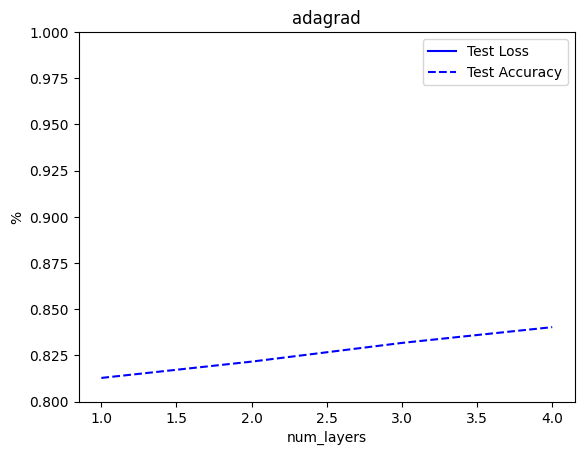

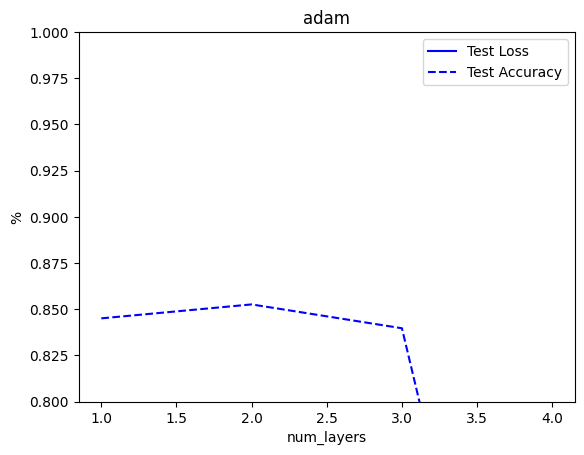

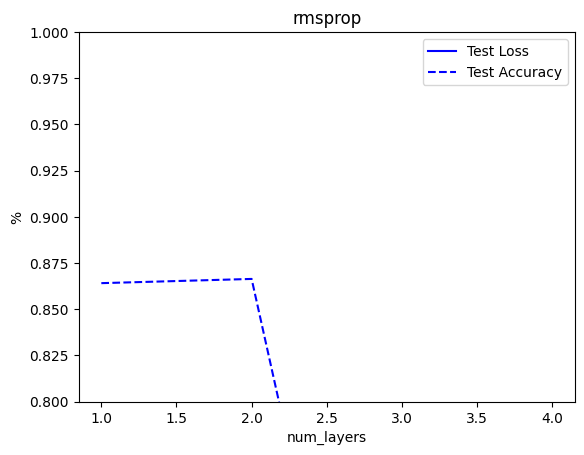

In [68]:
optimizer_name = ["adagrad", "adam", "rmsprop"]
layers = [1, 2,3,4]
layer_table_dict = {}
i = 0
on = 0
for opt_nm in optimizer_name:
    if opt_nm == "adagrad":
        on = 1
    elif opt_nm == "adam":
        on = 2
    else:
        on = 3

    test_loss_vect = []
    test_acc_vect = []

    for lay in layers:
        new_hp = HyperParams()
        new_hp.OPTIM = opt_nm
        new_hp.LR = 0.001
        new_hp.N_LAYERS = lay
        model_name_str = f'lstm_{lay}layer_base_{opt_nm}_e32_h{100}_{1}ed'
        print(f'-----------------------------------------')
        print(f'------ New Model: {model_name_str} ------')
        rtr_vals = train_and_test_model_with_hparams(new_hp, model_name_str )
        layer_table_dict[i] = [float(on),
                                float(lay),   # number of layers
                                float(100), # number of hidden dim
                                float(1),
                                float(rtr_vals['num_params']),
                                rtr_vals["test_loss"],
                                rtr_vals["test_acc"],
                                rtr_vals["train_losses"],
                                rtr_vals["train_accs"],
                                rtr_vals["valid_losses"],
                                rtr_vals["valid_accs"]]
        print(f'-----------------------------------------')
        test_loss_vect.append(rtr_vals["test_loss"])
        test_acc_vect.append(rtr_vals["test_acc"])
        i = i + 1

    plt_title = opt_nm
    parameter_name = 'num_layers'
    parameter_setting_vect = layers
    plot_test_loss_and_accuracy_over_parameter_change(test_loss_vect, test_acc_vect, parameter_setting_vect, parameter_name, plt_title)

In [69]:
df = pd.DataFrame.from_dict(data=layer_table_dict, orient="index", columns = ["OptimType", "NumLayers", "NumHiddenDim", "NumEmbededDim", "NumParams",  ""
  "Test_Loss", "Test_Acc",                                                                                                                                "Train_Loss",
  "Train_Acc",
  "Valid_Loss",
  "Valid_Acc",  ])
df

,OptimType,NumLayers,NumHiddenDim,NumEmbededDim,NumParams,Test_Loss,Test_Acc,Train_Loss,Train_Acc,Valid_Loss,Valid_Acc
0,1.0,1.0,100.0,1.0,102202.0,0.492422,0.812798,"[0.6931541081977217, 0.6929038506664642, 0.651...","[0.4996371643183983, 0.5299983859878696, 0.648...","[0.6931004940338854, 0.6921972992285242, 0.651...","[0.5027515905083351, 0.6193003317095199, 0.678..."
1,1.0,2.0,100.0,1.0,183002.0,0.402142,0.821627,"[0.6931563993022867, 0.6927227165601025, 0.632...","[0.5009010241456228, 0.5210045819413172, 0.694...","[0.6930876419229327, 0.6855955528763106, 0.485...","[0.5027515905083351, 0.5172956124791559, 0.792..."
2,1.0,3.0,100.0,1.0,263802.0,0.383692,0.831746,"[0.6931308514451328, 0.6931339402721353, 0.671...","[0.5049902300312095, 0.5007950244701072, 0.578...","[0.6931233248620663, 0.6930507680155197, 0.657...","[0.5027515905083351, 0.5550314671588394, 0.559..."
3,1.0,4.0,100.0,1.0,344602.0,0.363901,0.840278,"[0.6931686014345247, 0.6931629370336663, 0.683...","[0.49945369909887444, 0.4978473718035711, 0.54...","[0.6931403526720011, 0.6931466314027894, 0.592...","[0.5027515905083351, 0.49724844435475907, 0.65..."
4,2.0,1.0,100.0,1.0,102202.0,0.402540,0.845040,"[0.6891940813358516, 0.5509744842575021, 0.377...","[0.5339571260426142, 0.7291870715683454, 0.836...","[0.6731330662403466, 0.5128323503260342, 0.420...","[0.5768475026454566, 0.7517688870429993, 0.811..."
5,2.0,2.0,100.0,1.0,183002.0,0.383443,0.852579,"[0.6904777922042429, 0.39927419991525887, 0.21...","[0.5421110723116627, 0.8254403324976359, 0.918...","[0.5883986140197178, 0.4573044051539223, 0.384...","[0.7236635426305374, 0.7869497031535743, 0.850..."
6,2.0,3.0,100.0,1.0,263802.0,0.368382,0.839683,"[0.6897021365492311, 0.5836437386192688, 0.358...","[0.5164669103818397, 0.6954093487295386, 0.844...","[0.7244228641941862, 0.5076714686627658, 0.373...","[0.72268083410443, 0.7761399543510293, 0.83333..."
7,2.0,4.0,100.0,1.0,344602.0,0.693169,0.498710,"[0.6932700211054659, 0.6932192047981367, 0.693...","[0.49722767161996395, 0.49787591091574057, 0.4...","[0.6931384307033611, 0.6931739269562487, 0.693...","[0.5027515905083351, 0.49724844435475907, 0.50..."
8,3.0,1.0,100.0,1.0,102202.0,0.348304,0.864087,"[0.6921269578476474, 0.6099212711804534, 0.406...","[0.5473132922224803, 0.6813804824874826, 0.807...","[0.6873849416678807, 0.7163870975656329, 0.357...","[0.5432390109548029, 0.5035377510313718, 0.848..."
9,3.0,2.0,100.0,1.0,183002.0,0.327672,0.866369,"[0.6938101748897605, 0.6040296984045472, 0.297...","[0.552857975600517, 0.6791707632476336, 0.8763...","[0.6434842876668246, 0.4955803521399228, 0.337...","[0.6305031630228151, 0.7788915251785854, 0.865..."


### Lab 2 (d) Wider LSTMs

-----------------------------------------
------ New Model: lstm_1layer_base_adagrad_e32_h1_1ed ------
Length of vocabulary is 60800
The model has 60,820 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 107.44it/s]
Saving ...
epoch: 1
train_loss: 0.693, train_acc: 0.503
valid_loss: 0.693, valid_acc: 0.535
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 116.99it/s]
Saving ...
epoch: 2
train_loss: 0.693, train_acc: 0.523
valid_loss: 0.693, valid_acc: 0.541
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 111.68it/s]
Saving ...
epoch: 3
train_loss: 0.693, train_acc: 0.561
valid_loss: 0.693, valid_acc: 0.551
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 115.80it/s]
Saving ...
epoch: 4
train_loss: 0.693, train_acc: 0.607
valid_loss: 0.693, valid_acc: 0.553
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 107.19it/s]
Saving ...
epoch: 5
train_loss: 0.693, train_acc: 0.606
valid_loss: 0.693, valid_acc: 0.558
evaluating...: 100%|██████████| 105/105 [00:0

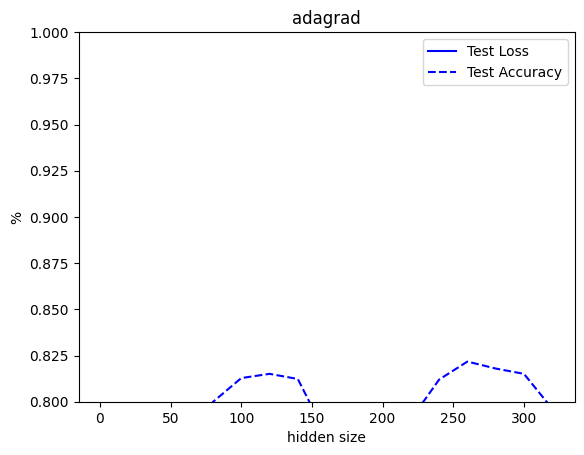

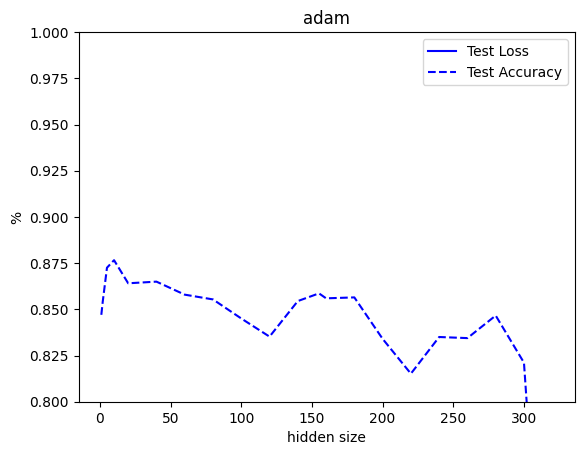

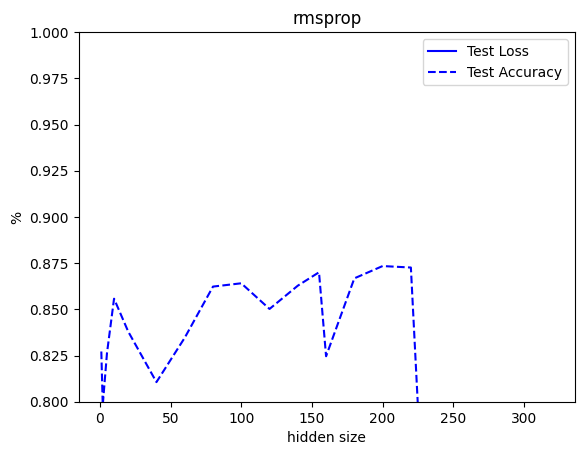

In [15]:
optimizer_name = ["adagrad", "adam", "rmsprop"]
hd_dims = [1,2,5,10,20,40,60,80,100,120,140,155,160,180,200,220,240,260,280,300,320]
hidden_table_dict = {}
i = 0
on = 0
for opt_nm in optimizer_name:
    if opt_nm == "adagrad":
        on = 1
    elif opt_nm == "adam":
        on = 2
    else:
        on = 3

    test_loss_vect = []
    test_acc_vect = []

    for hd in hd_dims:
        new_hp = HyperParams()
        new_hp.OPTIM = opt_nm
        new_hp.LR = 0.001
        new_hp.HIDDEN_DIM = hd
        model_name_str = f'lstm_{1}layer_base_{opt_nm}_e32_h{hd}_{1}ed'
        print(f'-----------------------------------------')
        print(f'------ New Model: {model_name_str} ------')
        rtr_vals = train_and_test_model_with_hparams(new_hp, model_name_str )
        hidden_table_dict[i] = [float(on),
                                   float(1),   # number of layers
                                   float(hd), # number of hidden dim
                                   float(1),
                                   float(rtr_vals['num_params']),
                                   rtr_vals["test_loss"],
                                   rtr_vals["test_acc"],
                                   rtr_vals["train_losses"],
                                   rtr_vals["train_accs"],
                                   rtr_vals["valid_losses"],
                                   rtr_vals["valid_accs"]]
        print(f'-----------------------------------------')
        test_loss_vect.append(rtr_vals["test_loss"])
        test_acc_vect.append(rtr_vals["test_acc"])
        i = i + 1

    plt_title = opt_nm
    parameter_name = 'hidden size'
    parameter_setting_vect = hd_dims
    plot_test_loss_and_accuracy_over_parameter_change(test_loss_vect, test_acc_vect, parameter_setting_vect, parameter_name, plt_title)

In [16]:
df = pd.DataFrame.from_dict(data=hidden_table_dict, orient="index", columns = ["OptimType",
                                                                               "NumLayers",
                                                                               "NumHiddenDim",
                                                                               "NumEmbededDim",
                                                                               "NumParams",
                                                                               "Test_Loss",
                                                                               "Test_Acc",
                                                                               "Train_Loss",
                                                                               "Train_Acc",
                                                                               "Valid_Loss",
                                                                               "Valid_Acc",  ])
df

,OptimType,NumLayers,NumHiddenDim,NumEmbededDim,NumParams,Test_Loss,Test_Acc,Train_Loss,Train_Acc,Valid_Loss,Valid_Acc
0,1.0,1.0,1.0,1.0,60820.0,0.692968,0.565873,"[0.6931391500446894, 0.6930921422292109, 0.693...","[0.5025766619264262, 0.5232224564029746, 0.560...","[0.6931269506238541, 0.6930950171542618, 0.693...","[0.5347877549675276, 0.5410770588326004, 0.551..."
1,1.0,1.0,2.0,1.0,60846.0,0.692617,0.601488,"[0.6931258337138451, 0.693000954307922, 0.6928...","[0.5111790762372213, 0.5381808720222891, 0.581...","[0.6930848168876936, 0.6929909789337302, 0.692...","[0.533608505186045, 0.561124232017769, 0.58136..."
2,1.0,1.0,5.0,1.0,60972.0,0.692818,0.556548,"[0.6931464263837631, 0.6931051190585307, 0.693...","[0.5018754229153672, 0.5036040584518485, 0.554...","[0.6931287635047481, 0.6930848944861934, 0.693...","[0.49724844435475907, 0.5113993843771377, 0.53..."
3,1.0,1.0,10.0,1.0,61342.0,0.692648,0.618948,"[0.693140804114407, 0.6930891585676637, 0.6929...","[0.5020996555890123, 0.5005870993823222, 0.569...","[0.6931079716052649, 0.6930524032070952, 0.692...","[0.5027515905083351, 0.5110063029910034, 0.566..."
4,1.0,1.0,20.0,1.0,62682.0,0.561145,0.766667,"[0.6931528635220985, 0.6930793907544385, 0.692...","[0.499898090019618, 0.5317596382474246, 0.5501...","[0.6931322104526016, 0.693024051639269, 0.6927...","[0.49724844435475907, 0.5161163660715211, 0.51..."
...,...,...,...,...,...,...,...,...,...,...,...
58,3.0,1.0,240.0,1.0,294562.0,0.660490,0.571131,"[0.6767613698358406, 0.6167217349352901, 0.557...","[0.5445939505753452, 0.6459393540473833, 0.701...","[0.6557743448131489, 0.6628648964863904, 0.693...","[0.5795990740353206, 0.5888364972933283, 0.585..."
59,3.0,1.0,260.0,1.0,334842.0,0.660660,0.573810,"[0.7140632181951444, 0.6523763238567195, 0.579...","[0.5099845221597854, 0.6028783615321329, 0.686...","[0.7543653081048209, 0.6585288992467916, 0.766...","[0.5147405812200511, 0.5766509625146974, 0.562..."
60,3.0,1.0,280.0,1.0,378322.0,0.664107,0.570635,"[0.6885336619533905, 0.6226312407075543, 0.547...","[0.5335249681178837, 0.6369822435183068, 0.716...","[0.6586821382900454, 0.6585016408056583, 0.709...","[0.5776336665423412, 0.5803852407437451, 0.572..."
61,3.0,1.0,300.0,1.0,425002.0,0.690024,0.538790,"[0.7317339761616433, 0.6890110548228434, 0.646...","[0.5127283250632352, 0.5363258497355735, 0.619...","[0.691391628868175, 0.6903342672114102, 0.7074...","[0.5226022145658169, 0.5302673128415953, 0.536..."


### Lab 2 (e) Larger Embedding Table

-----------------------------------------
------ New Model: lstm_1layer_base_adagrad_e32_h100_1ed ------
Length of vocabulary is 60800
The model has 102,202 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 92.22it/s]
Saving ...
epoch: 1
train_loss: 0.693, train_acc: 0.500
valid_loss: 0.693, valid_acc: 0.503
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 89.82it/s]
Saving ...
epoch: 2
train_loss: 0.693, train_acc: 0.530
valid_loss: 0.692, valid_acc: 0.619
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 88.17it/s]
Saving ...
epoch: 3
train_loss: 0.652, train_acc: 0.648
valid_loss: 0.652, valid_acc: 0.679
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 91.04it/s]
Saving ...
epoch: 4
train_loss: 0.522, train_acc: 0.796
valid_loss: 0.539, valid_acc: 0.778
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 101.27it/s]
Saving ...
epoch: 5
train_loss: 0.470, train_acc: 0.830
valid_loss: 0.499, valid_acc: 0.803
evaluating...: 100%|██████████| 105/105 [00:01

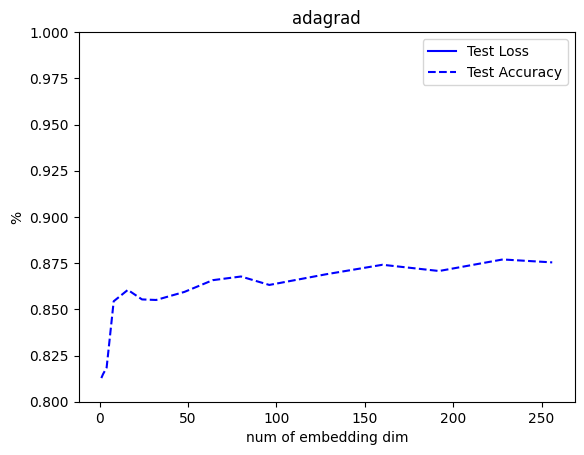

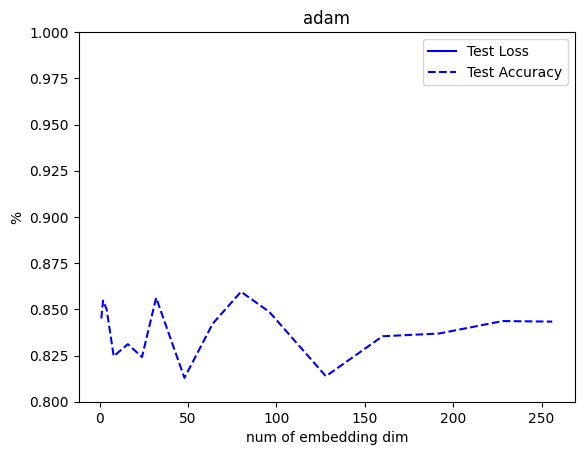

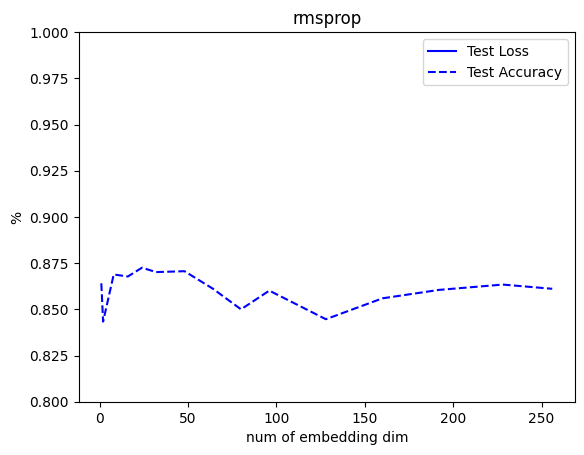

In [17]:
optimizer_name = ["adagrad", "adam", "rmsprop"]
e_dims = [1,2,4,8,16,24,32,48,64,80,96,128,160,192,228,256]
embedding_table_dict = {}
i = 0
on = 0
for opt_nm in optimizer_name:
    if opt_nm == "adagrad":
        on = 1
    elif opt_nm == "adam":
        on = 2
    else:
        on = 3

    test_loss_vect = []
    test_acc_vect = []

    for ed in e_dims:
        new_hp = HyperParams()
        new_hp.OPTIM = opt_nm
        new_hp.LR = 0.001
        new_hp.EMBEDDING_DIM = ed
        model_name_str = f'lstm_{1}layer_base_{opt_nm}_e32_h{100}_{ed}ed'
        print(f'-----------------------------------------')
        print(f'------ New Model: {model_name_str} ------')
        rtr_vals = train_and_test_model_with_hparams(new_hp, model_name_str )
        embedding_table_dict[i] = [float(on),
                                   float(1),   # number of layers
                                   float(100), # number of hidden dim
                                   float(ed),
                                   float(rtr_vals['num_params']),
                                   rtr_vals["test_loss"],
                                   rtr_vals["test_acc"],
                                   rtr_vals["train_losses"],
                                   rtr_vals["train_accs"],
                                   rtr_vals["valid_losses"],
                                   rtr_vals["valid_accs"]]
        print(f'-----------------------------------------')
        test_loss_vect.append(rtr_vals["test_loss"])
        test_acc_vect.append(rtr_vals["test_acc"])
        i = i + 1

    plt_title = opt_nm
    parameter_name = 'num of embedding dim'
    parameter_setting_vect = e_dims
    plot_test_loss_and_accuracy_over_parameter_change(test_loss_vect, test_acc_vect, parameter_setting_vect, parameter_name, plt_title)

In [18]:
df = pd.DataFrame.from_dict(data=embedding_table_dict, orient="index", columns = ["OptimType",
                                                                                  "NumLayers",
                                                                                  "NumHiddenDim",
                                                                                  "NumEmbededDim",
                                                                                  "NumParams",
                                                                                  "Test_Loss",
                                                                                  "Test_Acc",
                                                                                  "Train_Loss",
                                                                                  "Train_Acc",
                                                                                  "Valid_Loss",
                                                                                  "Valid_Acc",  ])
df

,OptimType,NumLayers,NumHiddenDim,NumEmbededDim,NumParams,Test_Loss,Test_Acc,Train_Loss,Train_Acc,Valid_Loss,Valid_Acc
0,1.0,1.0,100.0,1.0,102202.0,0.492422,0.812798,"[0.6931541081977217, 0.6929038506664642, 0.651...","[0.4996371643183983, 0.5299983859878696, 0.648...","[0.6931004940338854, 0.6921972992285242, 0.651...","[0.5027515905083351, 0.6193003317095199, 0.678..."
1,1.0,1.0,100.0,2.0,163402.0,0.478856,0.814980,"[0.6931445409173835, 0.6928415102501438, 0.588...","[0.5024706603729562, 0.5414872965584062, 0.726...","[0.6930851171601493, 0.685137003097894, 0.5353...","[0.49724844435475907, 0.6627358659258429, 0.78..."
2,1.0,1.0,100.0,4.0,285802.0,0.473220,0.818452,"[0.6931269356649216, 0.692604652332933, 0.5947...","[0.5015166481880292, 0.5639554974150984, 0.706...","[0.6930056056886349, 0.6755007572893826, 0.520...","[0.49724844435475907, 0.7501965592492301, 0.78..."
3,1.0,1.0,100.0,8.0,530602.0,0.390204,0.854365,"[0.6930987338497214, 0.6272332100835565, 0.421...","[0.5044846852348276, 0.655438700522462, 0.8450...","[0.6928000090257177, 0.48578454469734766, 0.43...","[0.5662342967852106, 0.8079795826156184, 0.830..."
4,1.0,1.0,100.0,16.0,1020202.0,0.375160,0.860516,"[0.6930188020614728, 0.5859606024337142, 0.401...","[0.5102943719249882, 0.7073141093939951, 0.857...","[0.692475973435168, 0.4635376755921346, 0.4183...","[0.5573899504148735, 0.8217374390026309, 0.836..."
5,1.0,1.0,100.0,24.0,1509802.0,0.366760,0.855357,"[0.6927967342611862, 0.5117703953834429, 0.356...","[0.5255463307850982, 0.7721502147308767, 0.876...","[0.6909457681314001, 0.4407157445291303, 0.405...","[0.4976415257408934, 0.8264544246331701, 0.839..."
6,1.0,1.0,100.0,32.0,1999402.0,0.368890,0.855060,"[0.694692910207461, 0.5067696895501385, 0.3557...","[0.5294398404147527, 0.7898402039318868, 0.877...","[0.675755040825538, 0.4313070889351503, 0.4008...","[0.5756682573624377, 0.8307783210052634, 0.841..."
7,1.0,1.0,100.0,48.0,2978602.0,0.365573,0.859425,"[0.6967454493862308, 0.46738927960395815, 0.32...","[0.5378628675251791, 0.8066821786638808, 0.889...","[0.6731858365940597, 0.40142078163488853, 0.36...","[0.5157232858100027, 0.843553475613864, 0.8579..."
8,1.0,1.0,100.0,64.0,3957802.0,0.330605,0.865774,"[0.6924789299703624, 0.5005780207784208, 0.316...","[0.5323548774196677, 0.8042889954292611, 0.887...","[0.6772880756630087, 0.4065485610714499, 0.352...","[0.6458333483282125, 0.8459119695537495, 0.861..."
9,1.0,1.0,100.0,80.0,4937002.0,0.334897,0.867758,"[0.6830516382439495, 0.41215036503256186, 0.28...","[0.5585208906702799, 0.8394243514701112, 0.903...","[0.5002184448377142, 0.39376031002908385, 0.38...","[0.7857704578705553, 0.8527908966226397, 0.843..."


### Lab 2 (f) Compound scaling of embedding_dim, hidden_dim, layers

In [37]:
optimizer_name = ["adagrad", "adam", "rmsprop"]
n_layers = [1]
hidden_dims = [155, 200]
e_dims = [32, 48]
lr = [0.0001, 0.00001]
drp = [0.0, 0.5]
table_dict = {}
i = 0
on = 0
for opt_nm in optimizer_name:
    if opt_nm == "adagrad":
        on = 1
    elif opt_nm == "adam":
        on = 2
    else:
        on = 3

    for learning_rate in lr:
        for dropout_rate in drp:
            for nl in n_layers:
                for hd in hidden_dims:
                    for ed in e_dims:
                        new_hp = HyperParams()
                        new_hp.OPTIM = opt_nm
                        new_hp.LR = learning_rate
                        new_hp.DROPOUT_RATE = dropout_rate
                        new_hp.N_LAYER = nl
                        new_hp.HIDDEN_DIM = hd
                        new_hp.EMBEDDING_DIM = ed
                        model_name_str = f'lstm_{nl}layer_base_{opt_nm}_e32_h{hd}_{ed}ed'
                        print(f'-----------------------------------------')
                        print(f'------ New Model: {model_name_str} ------')
                        rtr_vals = train_and_test_model_with_hparams(new_hp, model_name_str)
                        table_dict[i] = [float(on),
                                         float(nl),
                                         float(hd),
                                         float(ed),
                                         float(rtr_vals['num_params']),
                                         rtr_vals["test_loss"],
                                         rtr_vals["test_acc"],
                                         float(dropout_rate),
                                         float(learning_rate)]
                        print(f'-----------------------------------------')
                        i = i + 1

-----------------------------------------
------ New Model: lstm_1layer_base_adagrad_e32_h155_32ed ------
Length of vocabulary is 60800
The model has 2,063,092 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 84.79it/s]
Saving ...
epoch: 1
train_loss: 0.693, train_acc: 0.501
valid_loss: 0.693, valid_acc: 0.522
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 90.95it/s]
Saving ...
epoch: 2
train_loss: 0.693, train_acc: 0.529
valid_loss: 0.693, valid_acc: 0.538
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 90.17it/s]
Saving ...
epoch: 3
train_loss: 0.693, train_acc: 0.551
valid_loss: 0.693, valid_acc: 0.545
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 92.68it/s]
Saving ...
epoch: 4
train_loss: 0.693, train_acc: 0.554
valid_loss: 0.693, valid_acc: 0.552
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 78.22it/s]
Saving ...
epoch: 5
train_loss: 0.693, train_acc: 0.593
valid_loss: 0.693, valid_acc: 0.559
evaluating...: 100%|██████████| 105/105 [00:

/home/taylor/Duke/ECE661/projects/untitled/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Length of vocabulary is 60800
The model has 2,063,092 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 90.94it/s]
Saving ...
epoch: 1
train_loss: 0.693, train_acc: 0.501
valid_loss: 0.693, valid_acc: 0.512
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 92.50it/s]
Saving ...
epoch: 2
train_loss: 0.693, train_acc: 0.516
valid_loss: 0.693, valid_acc: 0.526
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 91.71it/s]
Saving ...
epoch: 3
train_loss: 0.693, train_acc: 0.526
valid_loss: 0.693, valid_acc: 0.546
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 91.94it/s]
Saving ...
epoch: 4
train_loss: 0.693, train_acc: 0.537
valid_loss: 0.693, valid_acc: 0.555
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 92.56it/s]
Saving ...
epoch: 5
train_loss: 0.693, train_acc: 0.552
valid_loss: 0.693, valid_acc: 0.564
evaluating...: 100%|██████████| 105/105 [00:01<00:00, 90.28it/s]
test_loss: 0.693, test_acc: 0.561
-----------------------------------------
---------

/home/taylor/Duke/ECE661/projects/untitled/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Length of vocabulary is 60800
The model has 3,045,812 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 92.50it/s]
Saving ...
epoch: 1
train_loss: 0.693, train_acc: 0.504
valid_loss: 0.693, valid_acc: 0.508
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 92.75it/s]
Saving ...
epoch: 2
train_loss: 0.693, train_acc: 0.523
valid_loss: 0.693, valid_acc: 0.524
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 93.34it/s]
Saving ...
epoch: 3
train_loss: 0.693, train_acc: 0.537
valid_loss: 0.693, valid_acc: 0.533
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 93.52it/s]
Saving ...
epoch: 4
train_loss: 0.693, train_acc: 0.545
valid_loss: 0.693, valid_acc: 0.541
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 92.92it/s]
Saving ...
epoch: 5
train_loss: 0.693, train_acc: 0.549
valid_loss: 0.693, valid_acc: 0.541
evaluating...: 100%|██████████| 105/105 [00:01<00:00, 89.53it/s]
test_loss: 0.693, test_acc: 0.537
-----------------------------------------
---------

/home/taylor/Duke/ECE661/projects/untitled/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Length of vocabulary is 60800
The model has 2,133,202 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 79.95it/s]
Saving ...
epoch: 1
train_loss: 0.693, train_acc: 0.501
valid_loss: 0.693, valid_acc: 0.498
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 81.12it/s]
Saving ...
epoch: 2
train_loss: 0.693, train_acc: 0.512
valid_loss: 0.693, valid_acc: 0.502
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 82.07it/s]
Saving ...
epoch: 3
train_loss: 0.693, train_acc: 0.520
valid_loss: 0.693, valid_acc: 0.503
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 79.29it/s]
Saving ...
epoch: 4
train_loss: 0.693, train_acc: 0.521
valid_loss: 0.693, valid_acc: 0.504
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 81.63it/s]
Saving ...
epoch: 5
train_loss: 0.693, train_acc: 0.523
valid_loss: 0.693, valid_acc: 0.506
evaluating...: 100%|██████████| 105/105 [00:01<00:00, 80.37it/s]
test_loss: 0.693, test_acc: 0.513
-----------------------------------------
---------

/home/taylor/Duke/ECE661/projects/untitled/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Length of vocabulary is 60800
The model has 3,118,802 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 78.68it/s]
Saving ...
epoch: 1
train_loss: 0.693, train_acc: 0.504
valid_loss: 0.693, valid_acc: 0.505
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 78.75it/s]
Saving ...
epoch: 2
train_loss: 0.693, train_acc: 0.523
valid_loss: 0.693, valid_acc: 0.512
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 80.51it/s]
Saving ...
epoch: 3
train_loss: 0.693, train_acc: 0.535
valid_loss: 0.693, valid_acc: 0.521
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 81.55it/s]
Saving ...
epoch: 4
train_loss: 0.693, train_acc: 0.543
valid_loss: 0.693, valid_acc: 0.525
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 80.87it/s]
Saving ...
epoch: 5
train_loss: 0.693, train_acc: 0.536
valid_loss: 0.693, valid_acc: 0.531
evaluating...: 100%|██████████| 105/105 [00:01<00:00, 80.06it/s]
test_loss: 0.693, test_acc: 0.532
-----------------------------------------
---------

/home/taylor/Duke/ECE661/projects/untitled/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Length of vocabulary is 60800
The model has 2,063,092 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 92.32it/s]
Saving ...
epoch: 1
train_loss: 0.693, train_acc: 0.494
valid_loss: 0.693, valid_acc: 0.502
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 92.90it/s]
Saving ...
epoch: 2
train_loss: 0.693, train_acc: 0.497
valid_loss: 0.693, valid_acc: 0.501
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 93.24it/s]
Saving ...
epoch: 3
train_loss: 0.693, train_acc: 0.495
valid_loss: 0.693, valid_acc: 0.502
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 92.82it/s]
Saving ...
epoch: 4
train_loss: 0.693, train_acc: 0.498
valid_loss: 0.693, valid_acc: 0.503
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 91.24it/s]
Saving ...
epoch: 5
train_loss: 0.693, train_acc: 0.500
valid_loss: 0.693, valid_acc: 0.505
evaluating...: 100%|██████████| 105/105 [00:01<00:00, 90.81it/s]
test_loss: 0.693, test_acc: 0.501
-----------------------------------------
---------

/home/taylor/Duke/ECE661/projects/untitled/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Length of vocabulary is 60800
The model has 3,045,812 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 93.82it/s]
Saving ...
epoch: 1
train_loss: 0.693, train_acc: 0.500
valid_loss: 0.693, valid_acc: 0.494
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 94.09it/s]
Saving ...
epoch: 2
train_loss: 0.693, train_acc: 0.502
valid_loss: 0.693, valid_acc: 0.494
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 94.88it/s]
Saving ...
epoch: 3
train_loss: 0.693, train_acc: 0.506
valid_loss: 0.693, valid_acc: 0.497
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 91.70it/s]
Saving ...
epoch: 4
train_loss: 0.693, train_acc: 0.505
valid_loss: 0.693, valid_acc: 0.500
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 94.78it/s]
Saving ...
epoch: 5
train_loss: 0.693, train_acc: 0.505
valid_loss: 0.693, valid_acc: 0.501
evaluating...: 100%|██████████| 105/105 [00:01<00:00, 93.72it/s]
test_loss: 0.693, test_acc: 0.512
-----------------------------------------
---------

/home/taylor/Duke/ECE661/projects/untitled/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Length of vocabulary is 60800
The model has 2,133,202 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 82.32it/s]
Saving ...
epoch: 1
train_loss: 0.693, train_acc: 0.499
valid_loss: 0.693, valid_acc: 0.488
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 82.29it/s]
Saving ...
epoch: 2
train_loss: 0.693, train_acc: 0.500
valid_loss: 0.693, valid_acc: 0.489
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 81.74it/s]
Saving ...
epoch: 3
train_loss: 0.693, train_acc: 0.502
valid_loss: 0.693, valid_acc: 0.489
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 80.00it/s]
Saving ...
epoch: 4
train_loss: 0.693, train_acc: 0.505
valid_loss: 0.693, valid_acc: 0.490
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 81.60it/s]
Saving ...
epoch: 5
train_loss: 0.693, train_acc: 0.499
valid_loss: 0.693, valid_acc: 0.492
evaluating...: 100%|██████████| 105/105 [00:01<00:00, 79.87it/s]
test_loss: 0.693, test_acc: 0.502
-----------------------------------------
---------

/home/taylor/Duke/ECE661/projects/untitled/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Length of vocabulary is 60800
The model has 3,118,802 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 82.12it/s]
Saving ...
epoch: 1
train_loss: 0.693, train_acc: 0.504
valid_loss: 0.693, valid_acc: 0.504
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 80.90it/s]
Saving ...
epoch: 2
train_loss: 0.693, train_acc: 0.505
valid_loss: 0.693, valid_acc: 0.506
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 79.46it/s]
Saving ...
epoch: 3
train_loss: 0.693, train_acc: 0.508
valid_loss: 0.693, valid_acc: 0.507
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 80.74it/s]
Saving ...
epoch: 4
train_loss: 0.693, train_acc: 0.504
valid_loss: 0.693, valid_acc: 0.507
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 80.97it/s]
Saving ...
epoch: 5
train_loss: 0.693, train_acc: 0.501
valid_loss: 0.693, valid_acc: 0.510
evaluating...: 100%|██████████| 105/105 [00:01<00:00, 80.48it/s]
test_loss: 0.693, test_acc: 0.506
-----------------------------------------
---------

/home/taylor/Duke/ECE661/projects/untitled/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Length of vocabulary is 60800
The model has 2,063,092 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 96.55it/s]
Saving ...
epoch: 1
train_loss: 0.693, train_acc: 0.508
valid_loss: 0.692, valid_acc: 0.503
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 96.08it/s]
Saving ...
epoch: 2
train_loss: 0.506, train_acc: 0.759
valid_loss: 0.369, valid_acc: 0.857
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 96.40it/s]
Saving ...
epoch: 3
train_loss: 0.260, train_acc: 0.910
valid_loss: 0.313, valid_acc: 0.873
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 96.65it/s]
Saving ...
epoch: 4
train_loss: 0.160, train_acc: 0.949
valid_loss: 0.285, valid_acc: 0.886
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 94.71it/s]
epoch: 5
train_loss: 0.099, train_acc: 0.972
valid_loss: 0.350, valid_acc: 0.876
evaluating...: 100%|██████████| 105/105 [00:01<00:00, 93.45it/s]
test_loss: 0.284, test_acc: 0.884
-----------------------------------------
--------------------

/home/taylor/Duke/ECE661/projects/untitled/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Length of vocabulary is 60800
The model has 3,045,812 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 91.88it/s]
Saving ...
epoch: 1
train_loss: 0.693, train_acc: 0.521
valid_loss: 0.691, valid_acc: 0.541
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 88.67it/s]
Saving ...
epoch: 2
train_loss: 0.467, train_acc: 0.790
valid_loss: 0.368, valid_acc: 0.858
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 88.47it/s]
Saving ...
epoch: 3
train_loss: 0.227, train_acc: 0.920
valid_loss: 0.295, valid_acc: 0.877
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 86.81it/s]
epoch: 4
train_loss: 0.140, train_acc: 0.957
valid_loss: 0.308, valid_acc: 0.880
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 90.70it/s]
epoch: 5
train_loss: 0.089, train_acc: 0.975
valid_loss: 0.383, valid_acc: 0.868
evaluating...: 100%|██████████| 105/105 [00:01<00:00, 83.88it/s]
test_loss: 0.291, test_acc: 0.879
-----------------------------------------
-------------------------------

/home/taylor/Duke/ECE661/projects/untitled/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Length of vocabulary is 60800
The model has 2,133,202 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 68.54it/s]
Saving ...
epoch: 1
train_loss: 0.693, train_acc: 0.512
valid_loss: 0.692, valid_acc: 0.560
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 69.85it/s]
Saving ...
epoch: 2
train_loss: 0.482, train_acc: 0.787
valid_loss: 0.351, valid_acc: 0.865
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 68.12it/s]
Saving ...
epoch: 3
train_loss: 0.249, train_acc: 0.914
valid_loss: 0.313, valid_acc: 0.882
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 73.26it/s]
Saving ...
epoch: 4
train_loss: 0.151, train_acc: 0.953
valid_loss: 0.291, valid_acc: 0.882
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 75.44it/s]
epoch: 5
train_loss: 0.103, train_acc: 0.972
valid_loss: 0.369, valid_acc: 0.869
evaluating...: 100%|██████████| 105/105 [00:01<00:00, 72.62it/s]
test_loss: 0.285, test_acc: 0.881
-----------------------------------------
--------------------

/home/taylor/Duke/ECE661/projects/untitled/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Length of vocabulary is 60800
The model has 3,118,802 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 75.66it/s]
Saving ...
epoch: 1
train_loss: 0.693, train_acc: 0.507
valid_loss: 0.691, valid_acc: 0.547
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 74.95it/s]
Saving ...
epoch: 2
train_loss: 0.445, train_acc: 0.798
valid_loss: 0.319, valid_acc: 0.869
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 72.98it/s]
epoch: 3
train_loss: 0.215, train_acc: 0.925
valid_loss: 0.331, valid_acc: 0.875
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 65.78it/s]
epoch: 4
train_loss: 0.130, train_acc: 0.960
valid_loss: 0.337, valid_acc: 0.880
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 73.24it/s]
epoch: 5
train_loss: 0.076, train_acc: 0.980
valid_loss: 0.366, valid_acc: 0.878
evaluating...: 100%|██████████| 105/105 [00:01<00:00, 71.33it/s]
test_loss: 0.315, test_acc: 0.870
-----------------------------------------
-----------------------------------------


/home/taylor/Duke/ECE661/projects/untitled/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Length of vocabulary is 60800
The model has 2,063,092 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 88.97it/s]
Saving ...
epoch: 1
train_loss: 0.693, train_acc: 0.501
valid_loss: 0.693, valid_acc: 0.523
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 82.62it/s]
Saving ...
epoch: 2
train_loss: 0.693, train_acc: 0.526
valid_loss: 0.693, valid_acc: 0.556
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 84.90it/s]
Saving ...
epoch: 3
train_loss: 0.693, train_acc: 0.546
valid_loss: 0.693, valid_acc: 0.539
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 84.53it/s]
Saving ...
epoch: 4
train_loss: 0.693, train_acc: 0.564
valid_loss: 0.693, valid_acc: 0.587
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 90.96it/s]
Saving ...
epoch: 5
train_loss: 0.693, train_acc: 0.616
valid_loss: 0.693, valid_acc: 0.606
evaluating...: 100%|██████████| 105/105 [00:01<00:00, 85.52it/s]
test_loss: 0.693, test_acc: 0.603
-----------------------------------------
---------

/home/taylor/Duke/ECE661/projects/untitled/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Length of vocabulary is 60800
The model has 3,045,812 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 90.03it/s]
Saving ...
epoch: 1
train_loss: 0.693, train_acc: 0.503
valid_loss: 0.693, valid_acc: 0.521
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 88.89it/s]
Saving ...
epoch: 2
train_loss: 0.693, train_acc: 0.530
valid_loss: 0.693, valid_acc: 0.541
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 94.07it/s]
Saving ...
epoch: 3
train_loss: 0.693, train_acc: 0.548
valid_loss: 0.693, valid_acc: 0.532
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 93.45it/s]
Saving ...
epoch: 4
train_loss: 0.693, train_acc: 0.564
valid_loss: 0.693, valid_acc: 0.548
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 88.48it/s]
Saving ...
epoch: 5
train_loss: 0.692, train_acc: 0.590
valid_loss: 0.692, valid_acc: 0.585
evaluating...: 100%|██████████| 105/105 [00:01<00:00, 83.26it/s]
test_loss: 0.692, test_acc: 0.582
-----------------------------------------
---------

/home/taylor/Duke/ECE661/projects/untitled/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Length of vocabulary is 60800
The model has 2,133,202 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 75.15it/s]
Saving ...
epoch: 1
train_loss: 0.693, train_acc: 0.501
valid_loss: 0.693, valid_acc: 0.498
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 74.80it/s]
Saving ...
epoch: 2
train_loss: 0.693, train_acc: 0.514
valid_loss: 0.693, valid_acc: 0.503
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 75.99it/s]
Saving ...
epoch: 3
train_loss: 0.693, train_acc: 0.531
valid_loss: 0.693, valid_acc: 0.526
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 77.62it/s]
Saving ...
epoch: 4
train_loss: 0.693, train_acc: 0.533
valid_loss: 0.693, valid_acc: 0.544
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 77.55it/s]
Saving ...
epoch: 5
train_loss: 0.693, train_acc: 0.562
valid_loss: 0.693, valid_acc: 0.558
evaluating...: 100%|██████████| 105/105 [00:01<00:00, 73.00it/s]
test_loss: 0.693, test_acc: 0.558
-----------------------------------------
---------

/home/taylor/Duke/ECE661/projects/untitled/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Length of vocabulary is 60800
The model has 3,118,802 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 77.65it/s]
Saving ...
epoch: 1
train_loss: 0.693, train_acc: 0.503
valid_loss: 0.693, valid_acc: 0.497
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 67.41it/s]
Saving ...
epoch: 2
train_loss: 0.693, train_acc: 0.521
valid_loss: 0.693, valid_acc: 0.505
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 78.90it/s]
Saving ...
epoch: 3
train_loss: 0.693, train_acc: 0.548
valid_loss: 0.693, valid_acc: 0.516
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 75.57it/s]
Saving ...
epoch: 4
train_loss: 0.693, train_acc: 0.578
valid_loss: 0.693, valid_acc: 0.530
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 77.75it/s]
Saving ...
epoch: 5
train_loss: 0.692, train_acc: 0.566
valid_loss: 0.692, valid_acc: 0.592
evaluating...: 100%|██████████| 105/105 [00:01<00:00, 78.45it/s]
test_loss: 0.692, test_acc: 0.583
-----------------------------------------
---------

/home/taylor/Duke/ECE661/projects/untitled/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Length of vocabulary is 60800
The model has 2,063,092 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 84.84it/s]
Saving ...
epoch: 1
train_loss: 0.732, train_acc: 0.534
valid_loss: 0.670, valid_acc: 0.586
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 86.36it/s]
Saving ...
epoch: 2
train_loss: 0.622, train_acc: 0.653
valid_loss: 0.584, valid_acc: 0.687
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 87.38it/s]
Saving ...
epoch: 3
train_loss: 0.445, train_acc: 0.807
valid_loss: 0.407, valid_acc: 0.834
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 86.37it/s]
Saving ...
epoch: 4
train_loss: 0.362, train_acc: 0.854
valid_loss: 0.405, valid_acc: 0.830
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 85.36it/s]
epoch: 5
train_loss: 0.226, train_acc: 0.915
valid_loss: 0.442, valid_acc: 0.808
evaluating...: 100%|██████████| 105/105 [00:01<00:00, 87.31it/s]
test_loss: 0.403, test_acc: 0.826
-----------------------------------------
--------------------

/home/taylor/Duke/ECE661/projects/untitled/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Length of vocabulary is 60800
The model has 3,045,812 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 90.18it/s]
Saving ...
epoch: 1
train_loss: 0.716, train_acc: 0.578
valid_loss: 0.587, valid_acc: 0.678
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 86.83it/s]
Saving ...
epoch: 2
train_loss: 0.385, train_acc: 0.836
valid_loss: 0.370, valid_acc: 0.846
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 82.51it/s]
epoch: 3
train_loss: 0.210, train_acc: 0.924
valid_loss: 0.373, valid_acc: 0.858
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 88.54it/s]
epoch: 4
train_loss: 0.142, train_acc: 0.951
valid_loss: 0.416, valid_acc: 0.856
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 89.67it/s]
epoch: 5
train_loss: 0.083, train_acc: 0.973
valid_loss: 0.534, valid_acc: 0.861
evaluating...: 100%|██████████| 105/105 [00:01<00:00, 90.86it/s]
test_loss: 0.369, test_acc: 0.841
-----------------------------------------
-----------------------------------------


/home/taylor/Duke/ECE661/projects/untitled/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Length of vocabulary is 60800
The model has 2,133,202 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 79.94it/s]
Saving ...
epoch: 1
train_loss: 0.629, train_acc: 0.658
valid_loss: 0.492, valid_acc: 0.755
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 80.96it/s]
Saving ...
epoch: 2
train_loss: 0.502, train_acc: 0.781
valid_loss: 0.473, valid_acc: 0.812
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 80.12it/s]
Saving ...
epoch: 3
train_loss: 0.279, train_acc: 0.893
valid_loss: 0.366, valid_acc: 0.855
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 76.98it/s]
epoch: 4
train_loss: 0.192, train_acc: 0.930
valid_loss: 0.414, valid_acc: 0.854
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 79.38it/s]
epoch: 5
train_loss: 0.150, train_acc: 0.948
valid_loss: 0.483, valid_acc: 0.852
evaluating...: 100%|██████████| 105/105 [00:01<00:00, 78.47it/s]
test_loss: 0.375, test_acc: 0.852
-----------------------------------------
-------------------------------

/home/taylor/Duke/ECE661/projects/untitled/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Length of vocabulary is 60800
The model has 3,118,802 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 79.17it/s]
Saving ...
epoch: 1
train_loss: 0.642, train_acc: 0.623
valid_loss: 0.469, valid_acc: 0.805
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 77.42it/s]
epoch: 2
train_loss: 0.373, train_acc: 0.851
valid_loss: 0.494, valid_acc: 0.764
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 79.67it/s]
Saving ...
epoch: 3
train_loss: 0.238, train_acc: 0.912
valid_loss: 0.393, valid_acc: 0.844
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 80.24it/s]
epoch: 4
train_loss: 0.148, train_acc: 0.949
valid_loss: 0.419, valid_acc: 0.838
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 78.04it/s]
epoch: 5
train_loss: 0.091, train_acc: 0.971
valid_loss: 0.481, valid_acc: 0.832
evaluating...: 100%|██████████| 105/105 [00:01<00:00, 77.57it/s]
test_loss: 0.394, test_acc: 0.844
-----------------------------------------
-----------------------------------------


/home/taylor/Duke/ECE661/projects/untitled/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Length of vocabulary is 60800
The model has 2,063,092 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 90.70it/s]
Saving ...
epoch: 1
train_loss: 0.693, train_acc: 0.508
valid_loss: 0.692, valid_acc: 0.504
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 93.64it/s]
Saving ...
epoch: 2
train_loss: 0.709, train_acc: 0.519
valid_loss: 0.681, valid_acc: 0.511
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 93.65it/s]
Saving ...
epoch: 3
train_loss: 0.602, train_acc: 0.623
valid_loss: 0.410, valid_acc: 0.828
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 93.21it/s]
Saving ...
epoch: 4
train_loss: 0.323, train_acc: 0.876
valid_loss: 0.317, valid_acc: 0.869
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 85.62it/s]
Saving ...
epoch: 5
train_loss: 0.221, train_acc: 0.919
valid_loss: 0.295, valid_acc: 0.879
evaluating...: 100%|██████████| 105/105 [00:01<00:00, 85.35it/s]
test_loss: 0.294, test_acc: 0.880
-----------------------------------------
---------

/home/taylor/Duke/ECE661/projects/untitled/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Length of vocabulary is 60800
The model has 3,045,812 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 78.53it/s]
Saving ...
epoch: 1
train_loss: 0.693, train_acc: 0.522
valid_loss: 0.691, valid_acc: 0.546
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 89.25it/s]
Saving ...
epoch: 2
train_loss: 0.538, train_acc: 0.754
valid_loss: 0.432, valid_acc: 0.825
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 91.01it/s]
Saving ...
epoch: 3
train_loss: 0.317, train_acc: 0.891
valid_loss: 0.331, valid_acc: 0.869
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 91.75it/s]
Saving ...
epoch: 4
train_loss: 0.207, train_acc: 0.933
valid_loss: 0.300, valid_acc: 0.881
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 90.74it/s]
epoch: 5
train_loss: 0.140, train_acc: 0.957
valid_loss: 0.337, valid_acc: 0.873
evaluating...: 100%|██████████| 105/105 [00:01<00:00, 91.40it/s]
test_loss: 0.293, test_acc: 0.881
-----------------------------------------
--------------------

/home/taylor/Duke/ECE661/projects/untitled/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Length of vocabulary is 60800
The model has 2,133,202 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 81.65it/s]
Saving ...
epoch: 1
train_loss: 0.693, train_acc: 0.514
valid_loss: 0.692, valid_acc: 0.567
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 78.21it/s]
Saving ...
epoch: 2
train_loss: 0.718, train_acc: 0.561
valid_loss: 0.667, valid_acc: 0.596
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 79.78it/s]
Saving ...
epoch: 3
train_loss: 0.593, train_acc: 0.738
valid_loss: 0.430, valid_acc: 0.815
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 80.29it/s]
Saving ...
epoch: 4
train_loss: 0.342, train_acc: 0.867
valid_loss: 0.337, valid_acc: 0.866
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 77.79it/s]
Saving ...
epoch: 5
train_loss: 0.236, train_acc: 0.915
valid_loss: 0.321, valid_acc: 0.876
evaluating...: 100%|██████████| 105/105 [00:01<00:00, 77.53it/s]
test_loss: 0.315, test_acc: 0.874
-----------------------------------------
---------

/home/taylor/Duke/ECE661/projects/untitled/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Length of vocabulary is 60800
The model has 3,118,802 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 79.60it/s]
Saving ...
epoch: 1
train_loss: 0.693, train_acc: 0.509
valid_loss: 0.691, valid_acc: 0.545
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 72.64it/s]
Saving ...
epoch: 2
train_loss: 0.687, train_acc: 0.592
valid_loss: 0.481, valid_acc: 0.810
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 77.84it/s]
Saving ...
epoch: 3
train_loss: 0.359, train_acc: 0.862
valid_loss: 0.324, valid_acc: 0.868
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 76.75it/s]
Saving ...
epoch: 4
train_loss: 0.224, train_acc: 0.920
valid_loss: 0.307, valid_acc: 0.880
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 79.05it/s]
Saving ...
epoch: 5
train_loss: 0.152, train_acc: 0.950
valid_loss: 0.286, valid_acc: 0.886
evaluating...: 100%|██████████| 105/105 [00:01<00:00, 77.29it/s]
test_loss: 0.281, test_acc: 0.886
-----------------------------------------


In [38]:
df = pd.DataFrame.from_dict(data=table_dict, orient="index", columns = ["OptimType",
                                                                        "NumLayers",
                                                                        "NumHiddenDim",
                                                                        "NumEmbededDim",
                                                                        "NumParams",
                                                                        "Test_Loss",
                                                                        "Test_Acc",
                                                                        "dropout_rate",
                                                                        "learning_rate"])
df

,OptimType,NumLayers,NumHiddenDim,NumEmbededDim,NumParams,Test_Loss,Test_Acc,dropout_rate,learning_rate
0,1.0,1.0,155.0,32.0,2063092.0,0.693033,0.560913,0.0,0.00010
1,1.0,1.0,155.0,48.0,3045812.0,0.692962,0.548710,0.0,0.00010
2,1.0,1.0,200.0,32.0,2133202.0,0.693037,0.528671,0.0,0.00010
3,1.0,1.0,200.0,48.0,3118802.0,0.692973,0.545437,0.0,0.00010
4,1.0,1.0,155.0,32.0,2063092.0,0.693083,0.560814,0.5,0.00010
5,1.0,1.0,155.0,48.0,3045812.0,0.693040,0.536905,0.5,0.00010
6,1.0,1.0,200.0,32.0,2133202.0,0.693096,0.513492,0.5,0.00010
7,1.0,1.0,200.0,48.0,3118802.0,0.693055,0.532242,0.5,0.00010
8,1.0,1.0,155.0,32.0,2063092.0,0.693143,0.506052,0.0,0.00001
9,1.0,1.0,155.0,48.0,3045812.0,0.693132,0.510020,0.0,0.00001


### Lab 2 (g) Bi-Directional LSTM, using best architecture from (f)

/home/taylor/Duke/ECE661/projects/untitled/venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Length of vocabulary is 60800
The model has 3,318,802 trainable parameters
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 64.16it/s]
Saving ...
epoch: 1
train_loss: 0.693, train_acc: 0.513
valid_loss: 0.690, valid_acc: 0.504
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 63.52it/s]
Saving ...
epoch: 2
train_loss: 0.450, train_acc: 0.800
valid_loss: 0.342, valid_acc: 0.866
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 64.36it/s]
Saving ...
epoch: 3
train_loss: 0.256, train_acc: 0.911
valid_loss: 0.298, valid_acc: 0.879
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 64.21it/s]
epoch: 4
train_loss: 0.172, train_acc: 0.943
valid_loss: 0.308, valid_acc: 0.874
evaluating...: 100%|██████████| 53/53 [00:00<00:00, 63.59it/s]
epoch: 5
train_loss: 0.116, train_acc: 0.964
valid_loss: 0.349, valid_acc: 0.879
evaluating...: 100%|██████████| 105/105 [00:01<00:00, 62.62it/s]
test_loss: 0.298, test_acc: 0.880


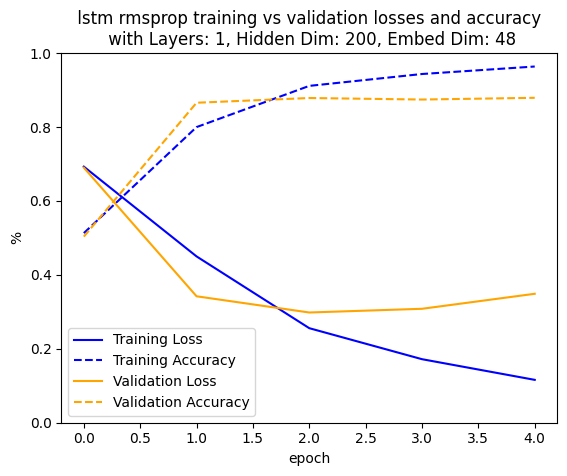

In [33]:
bi_hyperparams = HyperParams()
bi_hyperparams.OPTIM = "rmsprop"
bi_hyperparams.LR = 0.00001
bi_hyperparams.DROPOUT_RATE = 0.5
bi_hyperparams.N_LAYERS = 1
bi_hyperparams.HIDDEN_DIM = 200
bi_hyperparams.EMBEDDING_DIM = 48
bi_hyperparams.BIDIRECTIONAL = True
_ = train_and_test_model_with_hparams(bi_hyperparams , "lstm_Xlayer_base_rmsprop_e32_hX_bidirectional", output_plot=True)